In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import datetime
from stockstats import StockDataFrame

# libraries for plotting
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
sns.set(font="IPAexGothic", rc={'figure.figsize':(11,8)}) 
pd.options.display.float_format = '{:6.2f}'.format

In [2]:
def convert_df_to_stock_df(df):    
    sdf = df.copy()
    sdf.rename(columns={
        'Open': 'open',
        'High': 'high',
        'Low': 'low',
        'Close': 'close',
        'Adj Close': 'amount',
        'Volume': 'volume',
    }, inplace=True)
    sdf.index.names = ['date']
    return StockDataFrame(sdf)

data = yf.download(
        tickers = "VOO",
        period = "10y",
    
        # Valid intervals: [1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo]
        interval = "1d",
        group_by = 'ticker',
)

sdf = convert_df_to_stock_df(data)
sdf.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,amount,volume
date,,,,,,
2012-04-09,126.30,126.98,126.14,126.46,104.83,474850
2012-04-10,126.22,126.56,124.22,124.26,103.01,392650
2012-04-11,125.66,125.82,125.14,125.28,103.85,172850
2012-04-12,125.42,127.06,125.40,127.00,105.28,105550
2012-04-13,126.70,126.70,125.36,125.48,104.02,2416850


In [3]:
sdf['rsi']

# 売られすぎ、買われすぎのデータを追加
overbought_rsi = 70
oversold_rsi = 30

sdf['is_overbought'] = False
sdf['is_oversold'] = False
for index, row in sdf.iterrows():
    sdf.loc[index, 'is_overbought'] = sdf.loc[index]['rsi'] >= overbought_rsi
    sdf.loc[index, 'is_oversold'] = sdf.loc[index]['rsi'] <= oversold_rsi
sdf.head()

# rsiが計算できないデータを除外
for index, row in sdf.iterrows():
    if row['rsi'] == 0 or np.isnan(row['rsi']):
        print("Delete → ", index)
        sdf = sdf.drop(index)

# plot rsi
# plot_data = sdf.copy()
# plot_data['rsi']

# plt.ticklabel_format(style='plain', axis = 'y') 
# sns.lineplot(data = plot_data, x= 'date', y = 'rsi').set_title('RSI')
# plt.legend(labels=["RSI"])
# plt.figure()

# 売られすぎた日
print("Total oversold day : " ,(sdf['is_oversold'] == True).sum())

# 買われすぎた日
print("Total overbought day : " ,(sdf['is_overbought'] == True).sum())


# ------------------------

data = sdf.copy()

p = 0 # USD
add = 10 # USD

data['principal'] = p

# RSIの購入パターン
data['rsi_current_value'] = p # 現在の試算評価額（ドル建）
data['rsi_shares'] = p // sdf.loc[sdf.index[0], 'amount'] # 購入した株式数
data['rsi_capacity_to_buy'] = 0 # 買い付け余力金

# DCAの購入パターン
data['dca_shares'] = p // sdf.loc[sdf.index[0], 'amount'] # 購入した株式数
data['dca_capacity_to_buy'] = 0 # 買い付け余力金

previous_index = sdf.index[0]

for index, row in data.iterrows():
    data.loc[index, 'principal'] = data.loc[previous_index, 'principal'] + add;

    # RSI
    data.loc[index, 'rsi_capacity_to_buy'] = data.loc[previous_index, 'rsi_capacity_to_buy'] + add;
    if data.loc[index,'is_oversold'] and data.loc[index, 'rsi_capacity_to_buy'] >= data.loc[index, 'amount']:
        data.loc[index, 'rsi_shares'] = (data.loc[index, 'rsi_capacity_to_buy'] // data.loc[index, 'amount']) + data.loc[previous_index, 'rsi_shares']
        data.loc[index, 'rsi_capacity_to_buy'] = data.loc[index, 'rsi_capacity_to_buy'] % data.loc[index, 'amount']
    else:
        data.loc[index, 'rsi_shares'] = data.loc[previous_index, 'rsi_shares']
    data.loc[index, 'rsi_current_value'] = (data.loc[index, 'amount'] * data.loc[index, 'rsi_shares']) + data.loc[index, 'rsi_capacity_to_buy']
    
    # DCA 
    data.loc[index, 'dca_capacity_to_buy'] = data.loc[previous_index, 'dca_capacity_to_buy'] + add;
    if data.loc[index, 'dca_capacity_to_buy'] >= data.loc[index, 'amount']:
        data.loc[index, 'dca_shares'] = (data.loc[index, 'dca_capacity_to_buy'] // data.loc[index, 'amount']) + data.loc[previous_index, 'dca_shares']
        data.loc[index, 'dca_capacity_to_buy'] = data.loc[index, 'dca_capacity_to_buy'] % data.loc[index, 'amount']
    else:
        data.loc[index, 'dca_shares'] = data.loc[previous_index, 'dca_shares']
    data.loc[index, 'dca_current_value'] = (data.loc[index, 'amount'] * data.loc[index, 'dca_shares']) + data.loc[index, 'dca_capacity_to_buy']
    
    # 前日
    previous_index = index
    
result_data = data
result_data

Delete →  2012-04-09 00:00:00
Delete →  2012-04-10 00:00:00
Total oversold day :  45
Total overbought day :  181


,open,high,low,close,amount,volume,rs_14,rsi,is_overbought,is_oversold,principal,rsi_current_value,rsi_shares,rsi_capacity_to_buy,dca_shares,dca_capacity_to_buy,dca_current_value
date,,,,,,,,,,,,,,,,,
2012-04-11,125.66,125.82,125.14,125.28,103.85,172850,0.50,33.30,False,False,10,10.00,0.00,10.00,0.00,10.00,10.00
2012-04-12,125.42,127.06,125.40,127.00,105.28,105550,1.41,58.44,False,False,20,20.00,0.00,20.00,0.00,20.00,20.00
2012-04-13,126.70,126.70,125.36,125.48,104.02,2416850,0.75,43.01,False,False,30,30.00,0.00,30.00,0.00,30.00,30.00
2012-04-16,126.16,126.30,124.94,125.34,103.90,826850,0.72,41.91,False,False,40,40.00,0.00,40.00,0.00,40.00,40.00
2012-04-17,126.16,127.52,126.08,127.26,105.50,497450,1.37,57.81,False,False,50,50.00,0.00,50.00,0.00,50.00,50.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-04,416.45,419.96,415.72,419.85,419.85,5117200,1.46,59.33,False,False,25130,52903.97,124.00,842.57,132.00,107.87,55528.07
2022-04-05,418.56,420.82,413.50,414.66,414.66,4112000,1.19,54.33,False,False,25140,52270.41,124.00,852.57,132.00,117.87,54852.99
2022-04-06,410.76,412.66,407.64,410.46,410.46,5540700,1.03,50.62,False,False,25150,51759.60,124.00,862.57,132.00,127.87,54308.58


<Figure size 792x576 with 0 Axes>

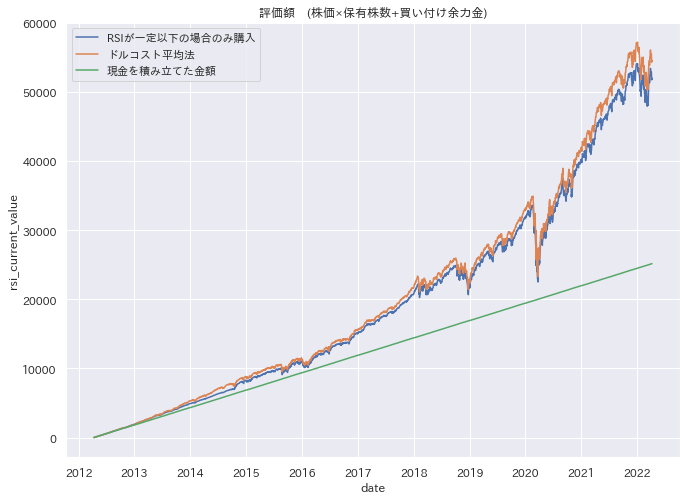

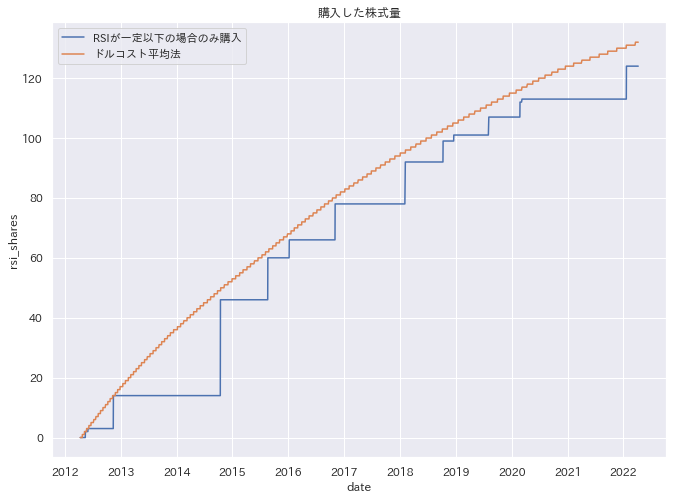

<Figure size 792x576 with 0 Axes>

In [4]:
plot_data = result_data.copy()

# now for the actual plot
sns.lineplot(data = plot_data, x= 'date', y = 'rsi_current_value')
sns.lineplot(data = plot_data, x= 'date', y = 'dca_current_value')
sns.lineplot(data = plot_data, x= 'date', y = 'principal').set_title('評価額　(株価×保有株数+買い付け余力金)')
plt.legend(labels=["RSIが一定以下の場合のみ購入","ドルコスト平均法", "現金を積み立てた金額"])
plt.figure()

sns.lineplot(data = plot_data, x= 'date', y = 'rsi_shares')
sns.lineplot(data = plot_data, x= 'date', y = 'dca_shares').set_title('購入した株式量')
plt.legend(labels=["RSIが一定以下の場合のみ購入","ドルコスト平均法"])
plt.figure()